Iñigo Martin Melero

## Participante 21

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_21_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0    5.244     10
1           50      5.0    5.244     10
2          100      5.0    5.244     10
3          150      5.0    5.244     10
4          200      5.0    5.244     10
...        ...      ...      ...    ...
49027  2451350      5.0    5.069     12
49028  2451400      5.0    5.069     12
49029  2451450      5.0    5.069     12
49030  2451500      5.0    5.069     12
49031  2451550      5.0    5.069     12

[49032 rows x 4 columns]


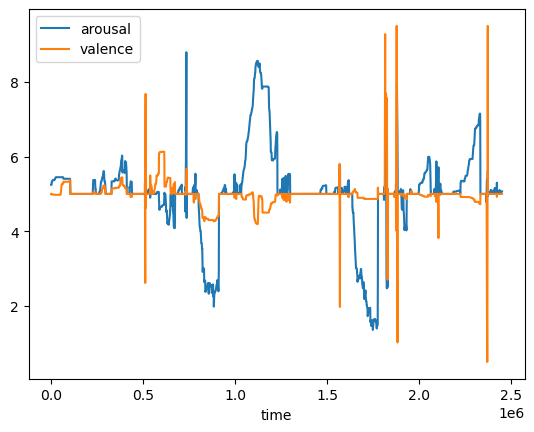

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_21_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.892  36.912  11.410  35.131  20.681    11.107     7.698   
1              1  0.899  37.047  11.453  35.141  20.688    11.230     7.780   
2              2  0.905  37.183  11.496  35.150  20.695    11.353     7.862   
3              3  0.912  37.299  11.497  35.179  20.702    11.273     8.026   
4              4  0.912  37.176  11.477  35.160  20.692    11.231     7.865   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.715  35.992  11.394  35.935  20.019     5.399     6.385   
2451580  2451580  0.715  36.108  11.390  35.954  20.029     5.440     6.385   
2451581  2451581  0.744  35.687  11.437  35.992  20.039     5.440     6.507   
2451582  2451582  0.738  35.817  11.422  35.993  20.033     5.521     6.427   
2451583  2451583  0.725  35.943  11.430  35.964  20.033     5.482     6.426   

         emg_trap  video  
0           8.190     10

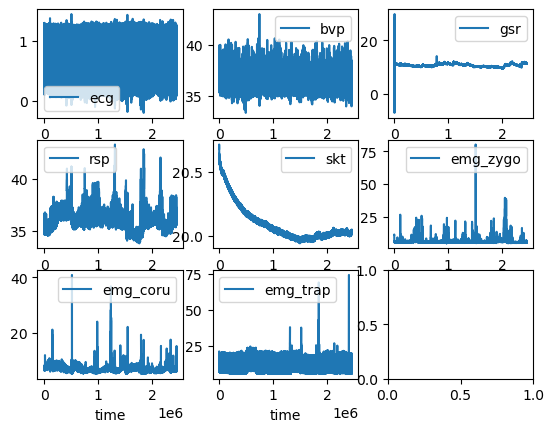

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

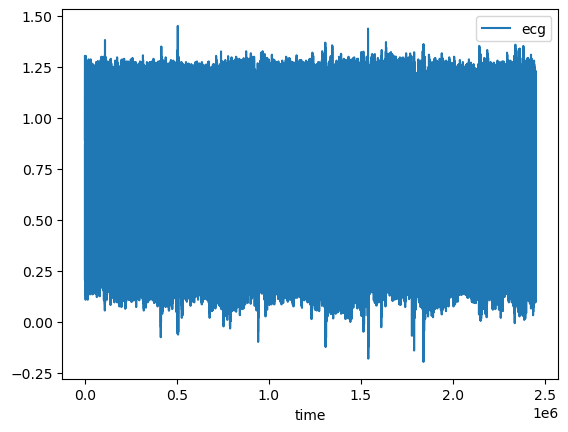

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

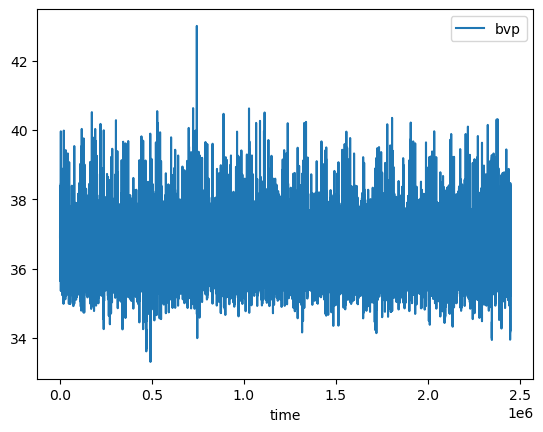

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

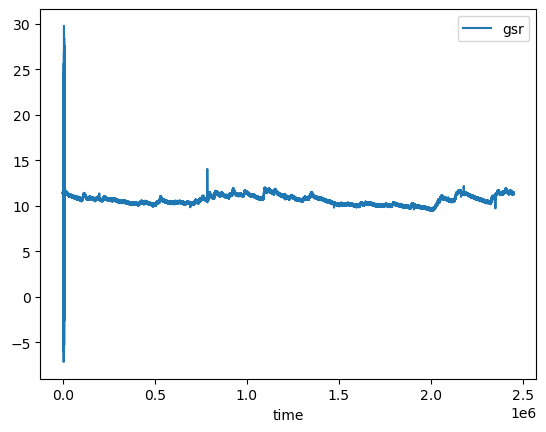

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

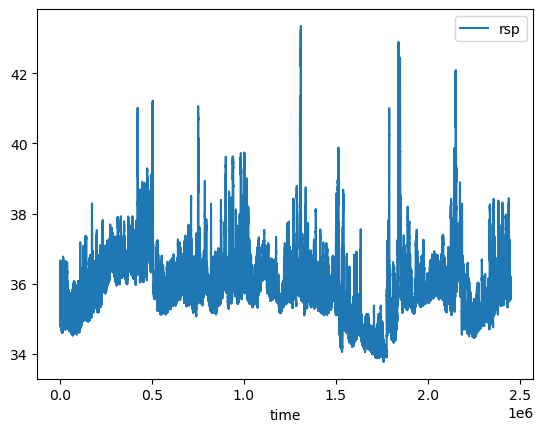

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

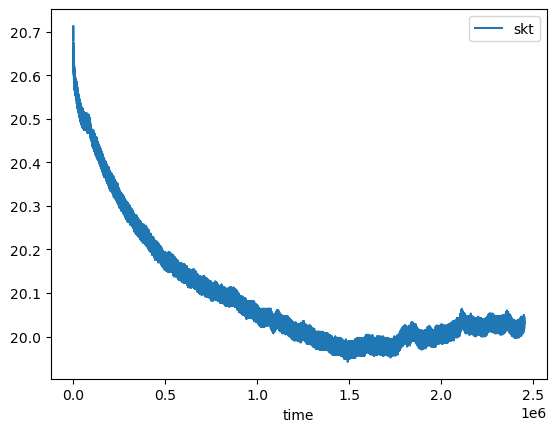

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

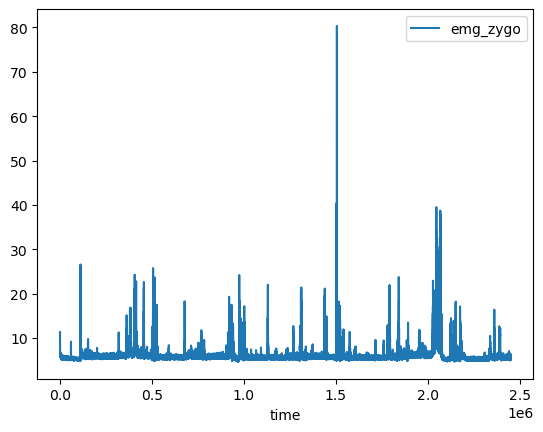

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

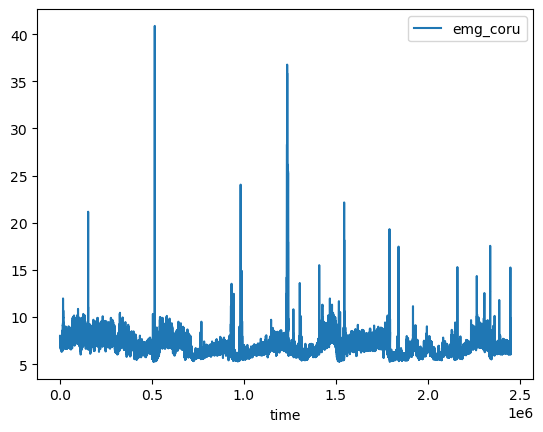

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

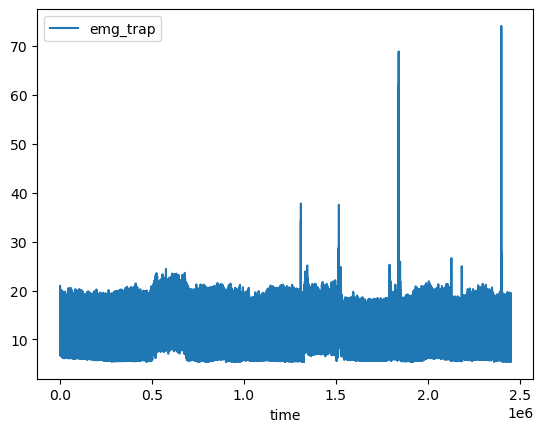

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

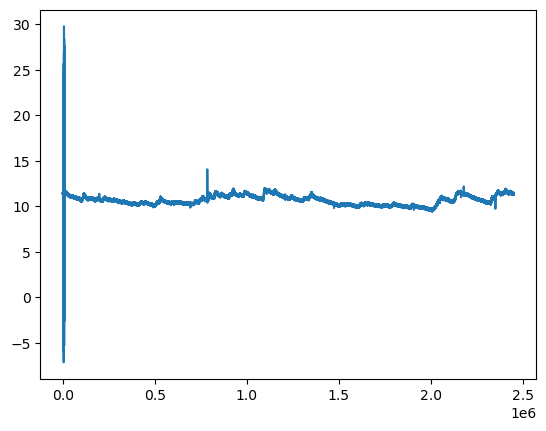

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

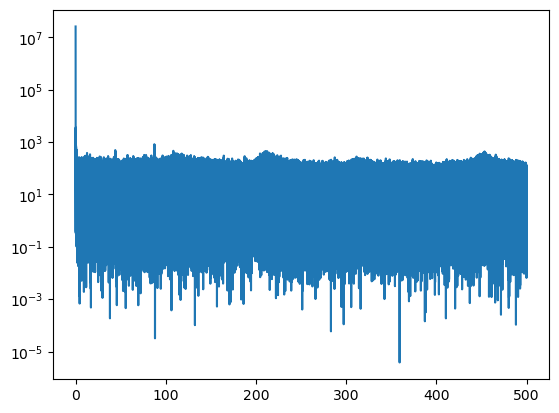

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

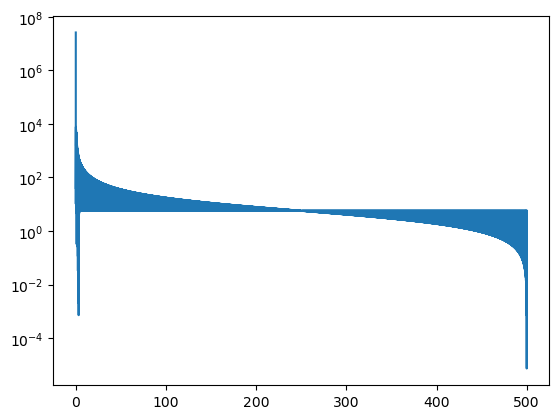

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

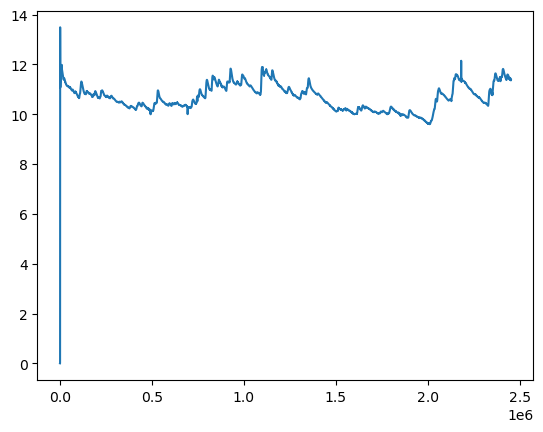

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  11.378
2451580  11.378
2451581  11.378
2451582  11.378
2451583  11.378

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

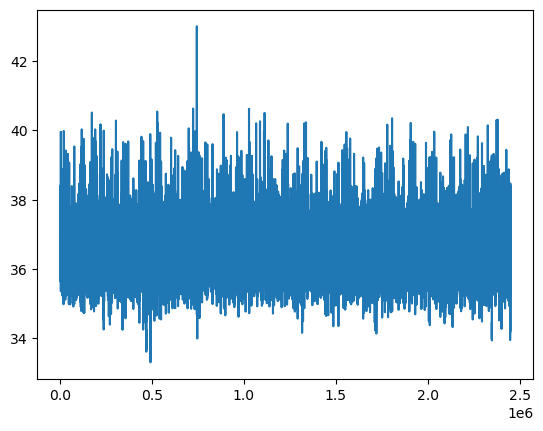

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

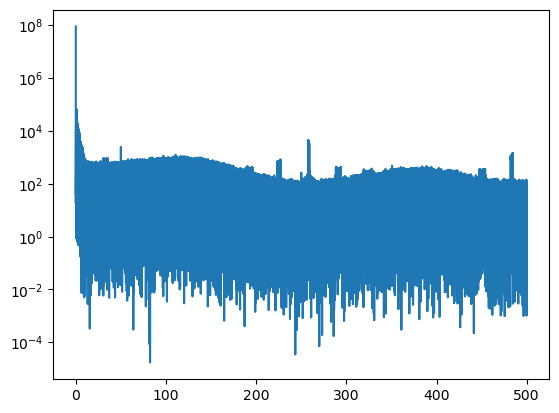

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

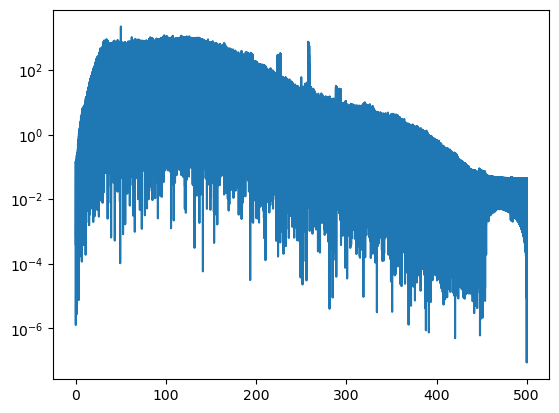

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

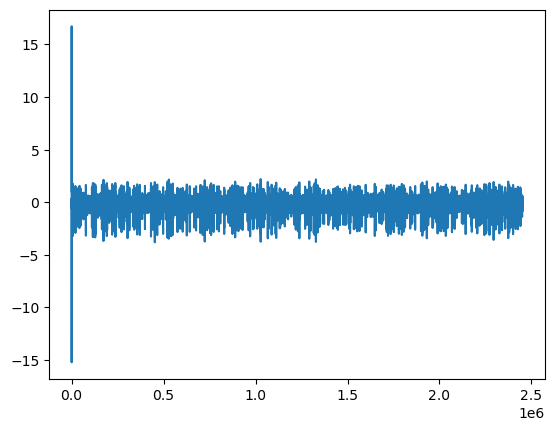

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.026
1        42.726
2        50.487
3        53.719
4        46.436
...         ...
2451579  37.052
2451580  37.029
2451581  37.025
2451582  37.018
2451583  36.955

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

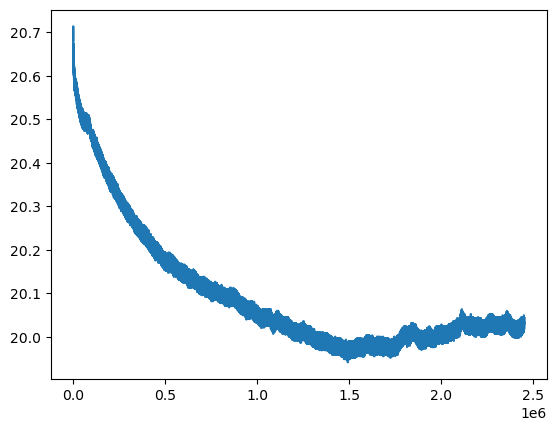

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

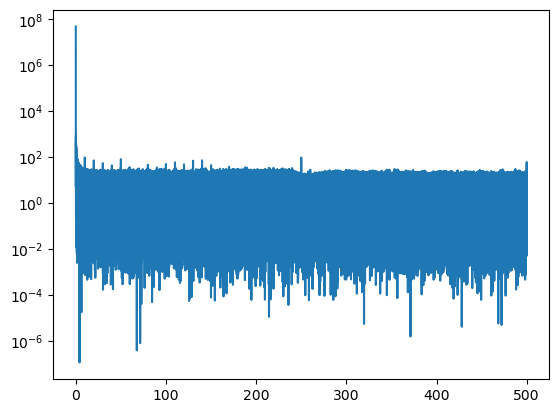

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

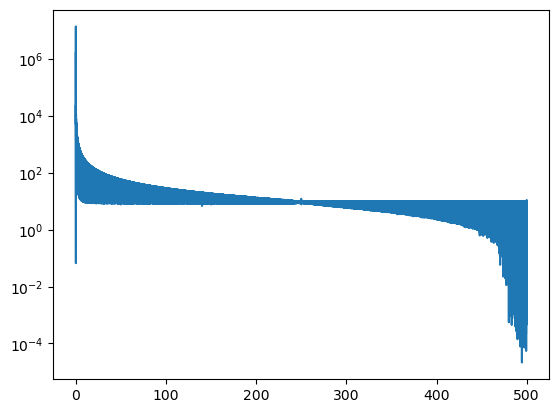

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

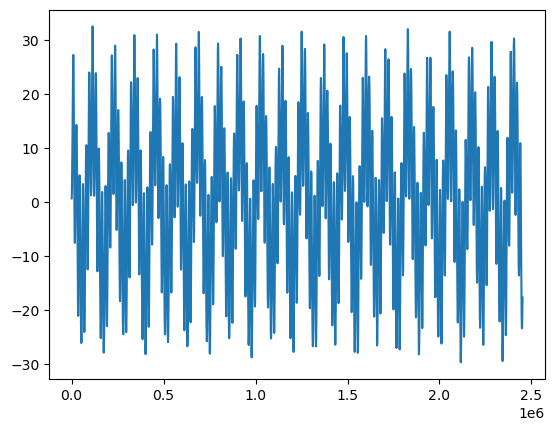

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.663
1        40.663
2        40.663
3        40.663
4        40.663
...         ...
2451579  22.330
2451580  22.333
2451581  22.337
2451582  22.340
2451583  22.343

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.892  35.131    11.107     7.698     8.190     10
1              1  0.899  35.141    11.230     7.780     8.354     10
2              2  0.905  35.150    11.353     7.862     8.519     10
3              3  0.912  35.179    11.273     8.026     8.642     10
4              4  0.912  35.160    11.231     7.865     8.562     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.715  35.935     5.399     6.385     5.812     12
2451580  2451580  0.715  35.954     5.440     6.385     5.891     12
2451581  2451581  0.744  35.992     5.440     6.507     6.014     12
2451582  2451582  0.738  35.993     5.521     6.427     5.934     12
2451583  2451583  0.725  35.964     5.482     6.426     5.974     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.892  35.131    11.107     7.698     8.190     10  38.026   
1              1  0.899  35.141    11.230     7.780     8.354     10  42.726   
2              2  0.905  35.150    11.353     7.862     8.519     10  50.487   
3              3  0.912  35.179    11.273     8.026     8.642     10  53.719   
4              4  0.912  35.160    11.231     7.865     8.562     10  46.436   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.715  35.935     5.399     6.385     5.812     12  37.052   
2451580  2451580  0.715  35.954     5.440     6.385     5.891     12  37.029   
2451581  2451581  0.744  35.992     5.440     6.507     6.014     12  37.025   
2451582  2451582  0.738  35.993     5.521     6.427     5.934     12  37.018   
2451583  2451583  0.725  35.964     5.482     6.426     5.974     12  36.955   

            gsr     skt  
0         0.000  40.663  
1         0.000  40.663  
2         0.000  40.663  
3         0.000  40.663  
4         0.000  40.663  
...         ...     ...  
2451579  11.378  22.330  
2451580  11.378  22.333  
2451581  11.378  22.337  
2451582  11.378  22.340  
2451583  11.378  22.343  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.596504  0.617381  0.511344  0.783793  0.276599  0.029511   
221502    221502  0.598689  0.610589  0.511344  0.783709  0.279849  0.027177   
221503    221503  0.589221  0.616858  0.511344  0.783642  0.281389  0.027148   
221504    221504  0.598689  0.631487  0.511344  0.783558  0.278139  0.028329   
221505    221505  0.596504  0.639324  0.511344  0.783474  0.279849  0.030693   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.617626  0.631139  0.490838  0.351647  0.274889  0.009424   
2331580  2331580  0.624909  0.622083  0.491274  0.351748  0.279678  0.011758   
2331581  2331581  0.615441  0.625218  0.491274  0.351832  0.279849  0.012940   
2331582  2331582  0.612527  0.634448  0.491274  0.351899  0.274889  0.005937   
2331583  2331583  0.631464  0.633577  0.491274  0.351983  0.274889  0.011729   

         emg_coru  emg_trap  video  
221501   0.322298  0.049655      1  
221502   0.318322  0.049603      1  
221503   0.322298  0.051760      1  
221504   0.318322  0.043238      1  
221505   0.322298  0.051707      1  
...           ...       ...    ...  
2331579  0.228452  0.127453      8  
2331580  0.228452  0.131661      8  
2331581  0.228452  0.123192      8  
2331582  0.220400  0.116669      8  
2331583  0.236405  0.118721      8  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0    5.244
1            5.0    5.246
2            5.0    5.249
3            5.0    5.251
4            5.0    5.253
...          ...      ...
2451579      5.0    5.230
2451580      5.0    5.233
2451581      5.0    5.236
2451582      5.0    5.239
2451583      5.0    5.242

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.596504  0.617381  0.511344  0.276599  0.783793  0.029511   
221502    221502  0.598689  0.610589  0.511344  0.279849  0.783709  0.027177   
221503    221503  0.589221  0.616858  0.511344  0.281389  0.783642  0.027148   
221504    221504  0.598689  0.631487  0.511344  0.278139  0.783558  0.028329   
221505    221505  0.596504  0.639324  0.511344  0.279849  0.783474  0.030693   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.617626  0.631139  0.490838  0.274889  0.351647  0.009424   
2331580  2331580  0.624909  0.622083  0.491274  0.279678  0.351748  0.011758   
2331581  2331581  0.615441  0.625218  0.491274  0.279849  0.351832  0.012940   
2331582  2331582  0.612527  0.634448  0.491274  0.274889  0.351899  0.005937   
2331583  2331583  0.631464  0.633577  0.491274  0.274889  0.351983  0.011729   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
221540   0.591406  0.617903  0.512216  0.278139  0.780806  0.027148  0.281539   
221560   0.603059  0.616858  0.512653  0.278139  0.779296  0.024813  0.240779   
221580   0.603059  0.626611  0.513089  0.281560  0.777768  0.029540  0.240779   
221600   0.605972  0.624347  0.513962  0.279849  0.776225  0.025966  0.203798   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.289876  0.636886  0.486475  0.266507  0.345153  0.010577  0.224277   
2331520  0.563001  0.625218  0.487784  0.266507  0.346797  0.010605  0.265136   
2331540  0.595776  0.616336  0.488656  0.271639  0.348459  0.011758  0.257083   
2331560  0.615441  0.599791  0.489965  0.284639  0.350103  0.012940  0.248832   
2331580  0.624909  0.622083  0.491274  0.279678  0.351748  0.011758  0.228452   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1      0.591406  0.617903  0.512216  0.278139  0.780806  0.027148  0.281539   
2      0.603059  0.616858  0.512653  0.278139  0.779296  0.024813  0.240779   
3      0.603059  0.626611  0.513089  0.281560  0.777768  0.029540  0.240779   
4      0.605972  0.624347  0.513962  0.279849  0.776225  0.025966  0.203798   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.289876  0.636886  0.486475  0.266507  0.345153  0.010577  0.224277   
63500  0.563001  0.625218  0.487784  0.266507  0.346797  0.010605  0.265136   
63501  0.595776  0.616336  0.488656  0.271639  0.348459  0.011758  0.257083   
63502  0.615441  0.599791  0.489965  0.284639  0.350103  0.012940  0.248832   
63503  0.624909  0.622083  0.491274  0.279678  0.351748  0.011758  0.228452   

       emg_trap  valence  arousal  
0      0.051812    5.000     5.00  
1      0.047446    5.000     5.00  
2      0.051812    5.000     5.00  
3      0.056125    5.000     5.00  
4      0.043133    5.000     5.00  
...         ...      ...      ...  
63499  0.578718    4.734     7.15  
63500  0.598548    4.734     7.15  
63501  0.341381    4.734     7.15  
63502  0.203040    4.734     7.15  
63503  0.131661    4.734     7.15  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1      0.591406  0.617903  0.512216  0.278139  0.780806  0.027148  0.281539   
2      0.603059  0.616858  0.512653  0.278139  0.779296  0.024813  0.240779   
3      0.603059  0.626611  0.513089  0.281560  0.777768  0.029540  0.240779   
4      0.605972  0.624347  0.513962  0.279849  0.776225  0.025966  0.203798   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.548434  0.618251  0.481675  0.251625  0.338558  0.009395  0.277364   
63496  0.529497  0.639150  0.482984  0.255046  0.340202  0.008242  0.244855   
63497  0.789512  0.599269  0.484293  0.260007  0.341864  0.010634  0.228651   
63498  0.393299  0.621212  0.485602  0.264967  0.343508  0.012940  0.220300   
63499  0.289876  0.636886  0.486475  0.266507  0.345153  0.010577  0.224277   

       emg_trap  valence  arousal  
0      0.051812    5.000     5.00  
1      0.047446    5.000     5.00  
2      0.051812    5.000     5.00  
3      0.056125    5.000     5.00  
4      0.043133    5.000     5.00  
...         ...      ...      ...  
63495  0.051760    4.734     7.15  
63496  0.041081    4.734     7.15  
63497  0.056125    4.734     7.15  
63498  0.161696    4.734     7.15  
63499  0.578718    4.734     7.15  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
 1   0.591406  0.617903  0.512216  0.278139  0.780806  0.027148  0.281539   
 2   0.603059  0.616858  0.512653  0.278139  0.779296  0.024813  0.240779   
 3   0.603059  0.626611  0.513089  0.281560  0.777768  0.029540  0.240779   
 4   0.605972  0.624347  0.513962  0.279849  0.776225  0.025966  0.203798   
 5   0.617626  0.626263  0.514834  0.281389  0.774698  0.024813  0.224277   
 6   0.593591  0.614943  0.515707  0.278139  0.773170  0.024785  0.199821   
 7   0.598689  0.607106  0.516579  0.283100  0.771627  0.031874  0.199821   
 8   0.617626  0.618251  0.517452  0.284810  0.770083  0.030693  0.216125   
 9   0.603059  0.643330  0.518761  0.279849  0.768539  0.027148  0.232429   
 10  0.593591  0.634100  0.519634  0.279849  0.766995  0.027148  0.248931   
 11  0.603059  0.633229  0.520942  0.276428  0.765451  0.024813  0.224277   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1     0.636562  0.636364  0.531850  0.279849  0.743703  0.025966  0.199920   
2     0.598689  0.631139  0.548429  0.276599  0.704838  0.021240  0.253007   
3     0.892935  0.617903  0.558901  0.369141  0.667081  0.024785  0.203897   
4     0.552804  0.617555  0.567190  0.480157  0.631538  0.021240  0.208072   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.708667  0.621909  0.345113  0.377523  0.161853  0.010605  0.334526   
2536  0.576839  0.691048  0.365183  0.299692  0.191774  0.007061  0.175365   
2537  0.603059  0.634274  0.393979  0.238454  0.226444  0.014179  0.273288   
2538  0.546249  0.616858  0.425393  0.225111  0.264772  0.014150  0.220400   
2539  0.574654  0.622257  0.458988  0.216900  0.305415  0.012940  0.167114   

             8         9        10  ...       193       194       195  \
0     0.051812  0.591406  0.617903  ...  0.612527  0.617381  0.531414   
1     0.285151  0.651129  0.616858  ...  0.596504  0.629223  0.547993   
2     0.032455  0.608157  0.623476  ...  0.857247  0.622605  0.558464   
3     0.056178  0.859432  0.634970  ...  0.555717  0.641066  0.566754   
4     0.034559  0.608157  0.604145  ...  0.589221  0.607454  0.573298   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.060439  0.742170  0.606409  ...  0.567371  0.634100  0.364311   
2536  0.041029  0.641661  0.627133  ...  0.653314  0.597005  0.392670   
2537  0.038872  0.584122  0.607106  ...  0.543336  0.616336  0.423647   
2538  0.045342  0.550619  0.618600  ...  0.584122  0.625392  0.457679   
2539  0.043133  0.572469  0.619296  ...  0.289876  0.636886  0.486475   

           196       197       198       199       200  valence  arousal  
0     0.279849  0.745264  0.027148  0.240680  0.492610  5.00000  5.00000  
1     0.276428  0.706382  0.020087  0.244855  0.038767  5.00000  5.00000  
2     0.365891  0.668557  0.025995  0.228452  0.064752  5.00000  5.00000  
3     0.481697  0.632898  0.021269  0.216224  0.034506  5.00000  5.00000  
4     0.493329  0.600326  0.027177  0.216224  0.025932  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.299692  0.190482  0.008213  0.175465  0.045342  4.74300  7.13048  
2536  0.239993  0.224984  0.016513  0.171389  0.041029  4.73916  7.14240  
2537  0.216900  0.263177  0.009424  0.224476  0.043133  4.73500  7.14872  
2538  0.215190  0.303771  0.010605  0.183716  0.043133  4.73400  7.15000  
2539  0.266507  0.345153  0.010577  0.224277  0.578718  4.73400  7.15000  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1     0.636562  0.636364  0.531850  0.279849  0.743703  0.025966  0.199920   
2     0.598689  0.631139  0.548429  0.276599  0.704838  0.021240  0.253007   
3     0.892935  0.617903  0.558901  0.369141  0.667081  0.024785  0.203897   
4     0.552804  0.617555  0.567190  0.480157  0.631538  0.021240  0.208072   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.708667  0.621909  0.345113  0.377523  0.161853  0.010605  0.334526   
2536  0.576839  0.691048  0.365183  0.299692  0.191774  0.007061  0.175365   
2537  0.603059  0.634274  0.393979  0.238454  0.226444  0.014179  0.273288   
2538  0.546249  0.616858  0.425393  0.225111  0.264772  0.014150  0.220400   
2539  0.574654  0.622257  0.458988  0.216900  0.305415  0.012940  0.167114   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub21.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1     0.636562  0.636364  0.531850  0.279849  0.743703  0.025966  0.199920   
2     0.598689  0.631139  0.548429  0.276599  0.704838  0.021240  0.253007   
3     0.892935  0.617903  0.558901  0.369141  0.667081  0.024785  0.203897   
4     0.552804  0.617555  0.567190  0.480157  0.631538  0.021240  0.208072   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.708667  0.621909  0.345113  0.377523  0.161853  0.010605  0.334526   
2536  0.576839  0.691048  0.365183  0.299692  0.191774  0.007061  0.175365   
2537  0.603059  0.634274  0.393979  0.238454  0.226444  0.014179  0.273288   
2538  0.546249  0.616858  0.425393  0.225111  0.264772  0.014150  0.220400   
2539  0.574654  0.622257  0.458988  0.216900  0.305415  0.012940  0.167114   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub21.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1     0.636562  0.636364  0.531850  0.279849  0.743703  0.025966  0.199920   
2     0.598689  0.631139  0.548429  0.276599  0.704838  0.021240  0.253007   
3     0.892935  0.617903  0.558901  0.369141  0.667081  0.024785  0.203897   
4     0.552804  0.617555  0.567190  0.480157  0.631538  0.021240  0.208072   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.708667  0.621909  0.345113  0.377523  0.161853  0.010605  0.334526   
2536  0.576839  0.691048  0.365183  0.299692  0.191774  0.007061  0.175365   
2537  0.603059  0.634274  0.393979  0.238454  0.226444  0.014179  0.273288   
2538  0.546249  0.616858  0.425393  0.225111  0.264772  0.014150  0.220400   
2539  0.574654  0.622257  0.458988  0.216900  0.305415  0.012940  0.167114   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub21.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1     0.636562  0.636364  0.531850  0.279849  0.743703  0.025966  0.199920   
2     0.598689  0.631139  0.548429  0.276599  0.704838  0.021240  0.253007   
3     0.892935  0.617903  0.558901  0.369141  0.667081  0.024785  0.203897   
4     0.552804  0.617555  0.567190  0.480157  0.631538  0.021240  0.208072   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.708667  0.621909  0.345113  0.377523  0.161853  0.010605  0.334526   
2536  0.576839  0.691048  0.365183  0.299692  0.191774  0.007061  0.175365   
2537  0.603059  0.634274  0.393979  0.238454  0.226444  0.014179  0.273288   
2538  0.546249  0.616858  0.425393  0.225111  0.264772  0.014150  0.220400   
2539  0.574654  0.622257  0.458988  0.216900  0.305415  0.012940  0.167114   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub21.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.612527  0.637757  0.511780  0.284810  0.782350  0.031903  0.314147   
1     0.636562  0.636364  0.531850  0.279849  0.743703  0.025966  0.199920   
2     0.598689  0.631139  0.548429  0.276599  0.704838  0.021240  0.253007   
3     0.892935  0.617903  0.558901  0.369141  0.667081  0.024785  0.203897   
4     0.552804  0.617555  0.567190  0.480157  0.631538  0.021240  0.208072   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.708667  0.621909  0.345113  0.377523  0.161853  0.010605  0.334526   
2536  0.576839  0.691048  0.365183  0.299692  0.191774  0.007061  0.175365   
2537  0.603059  0.634274  0.393979  0.238454  0.226444  0.014179  0.273288   
2538  0.546249  0.616858  0.425393  0.225111  0.264772  0.014150  0.220400   
2539  0.574654  0.622257  0.458988  0.216900  0.305415  0.012940  0.167114   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub21.csv', index=False)